In [1]:
pip install psycopg2

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import sys
import psycopg2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mc
import colorsys

In [2]:
sqluser = 'postgres'
dbname = 'mimic'
password='postgres'
schema_name = 'mimiciii'

In [3]:
# Connect to MIMIC-III
con = psycopg2.connect(dbname=dbname, user=sqluser, password=password)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

## Mortality numbers on the ICU across care units
We would like to know the mortality numbers of adult patients who were admitted to the ICU, and the distribution of these mortality numbers across the different ICUs. If a patient’s death was registered while the patient was on the ICU, or 6 hours before being admitted to, or 6 hours after leaving the ICU, we assume that the patient has died on the ICU.
### SQL query description
The following diagram visualizes the SQL query that is needed to obtain the ICU mortality numbers. We combine the Patients and Icustays tables based on the subject identifier, and select each patient’s date of birth and date of death, and the care unit and admission time corresponding to each ICU stay. The admission time and date of death together indicate whether or not a patient died on the ICU. The age (age >= 16) is again combined from the admission time and date of birth.
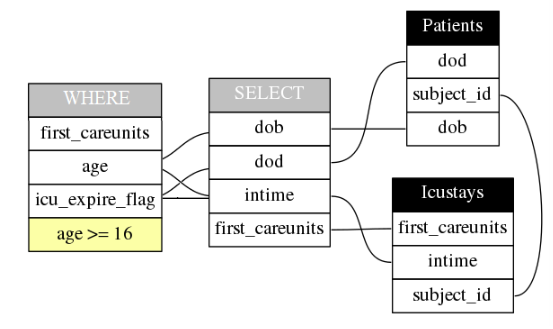

In [7]:
query = """
SELECT i.first_careunit,
round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age,
CASE WHEN p.dod IS NOT NULL
     AND p.dod >= i.intime - interval '6 hour'
     AND p.dod <= i.outtime + interval '6 hour' THEN 1
     ELSE 0 END AS icu_expire_flag
FROM mimiciii.patients p
INNER JOIN mimiciii.icustays i ON p.subject_id = i.subject_id
WHERE round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16;
"""

In [8]:
query_output = pd.read_sql_query(query,con)

In [9]:
print('Total mortality numbers: ', query_output.groupby('icu_expire_flag').icu_expire_flag.count())

Total mortality numbers:  icu_expire_flag
0    48858
1     4565
Name: icu_expire_flag, dtype: int64


In [18]:
print('Mortality numbers per intensive care unit: ')

Mortality numbers per intensive care unit: 


In [11]:
print(query_output.groupby(['first_careunit', 'icu_expire_flag']).icu_expire_flag.count())

first_careunit  icu_expire_flag
CCU             0                   7041
                1                    685
CSRU            0                   9010
                1                    301
MICU            0                  18865
                1                   2222
SICU            0                   8078
                1                    813
TSICU           0                   5864
                1                    544
Name: icu_expire_flag, dtype: int64


In [12]:
# Or in percentages:
print('Percentages mortality (% of total admissions): ',  query_output.groupby('icu_expire_flag').icu_expire_flag.count() /query_output.icu_expire_flag.count() * 100)

Percentages mortality (% of total admissions):  icu_expire_flag
0    91.454991
1     8.545009
Name: icu_expire_flag, dtype: float64


In [19]:
print('Percentages mortality per intensive care unit: ')

Percentages mortality per intensive care unit: 


In [14]:
print(query_output.groupby(['first_careunit', 'icu_expire_flag']).icu_expire_flag.count() / query_output.groupby('first_careunit').icu_expire_flag.count() * 100)

first_careunit  icu_expire_flag
CCU             0                  91.133834
                1                   8.866166
CSRU            0                  96.767265
                1                   3.232735
MICU            0                  89.462702
                1                  10.537298
SICU            0                  90.855922
                1                   9.144078
TSICU           0                  91.510612
                1                   8.489388
Name: icu_expire_flag, dtype: float64


In [15]:
# Visualize with a piechart:
care_units = ['CCU', 'CSRU', 'MICU', 'SICU', 'TSICU']
total = 0.0
percentages = []
for c in care_units:
    percentages.append(query_output.loc[(query_output['first_careunit'] == c) & (query_output['icu_expire_flag'] == 1)].shape[0])
    total += percentages[-1]
total = len(care_units) * [total]
percentages = np.array(percentages) / np.array(total) * 100

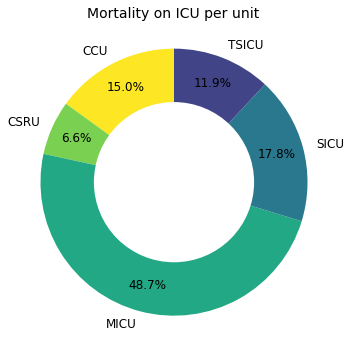

In [43]:
colors = cm.get_cmap("viridis_r")
colors = colors(np.arange(5)/5.)
fig1, ax1 = plt.subplots(figsize=(5, 5))
patches,texts,autotexts = ax1.pie(percentages, labels = care_units, autopct = '%1.1f%%', startangle = 90, colors = colors, pctdistance = 0.8)
for i in range(len(texts)):
    texts[i].set_fontsize('large')
    texts[i].set_fontweight('roman')
    autotexts[i].set_fontsize('large')
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Mortality on ICU per unit', fontsize='14', fontweight='roman') 
ax1.axis('equal')      
fig1.tight_layout() 
fig1.savefig('figures/mortality_ICU_piechart.jpg', dpi=400) 

## Mortality numbers in hospital across care units
We would also like to know the mortality numbers of adult patients who were admitted to hospital, and the distribution of those numbers across different ICUs. In this case, there is a variable called ‘hospital_expire_flag’ in the Admissions table that defines if a patient has died in hospital.\n
### SQL query description
The Patients and Icustays tables are combined based on the subject’s unique identifier, and the Admissions table is also joined based on the hospital admission’s identifier. We will need to select the hospital admission’s identifier, care unit, admission time and ‘hospital_expire_flag’. We also need the date of birth to obtain the age (age >= 16).
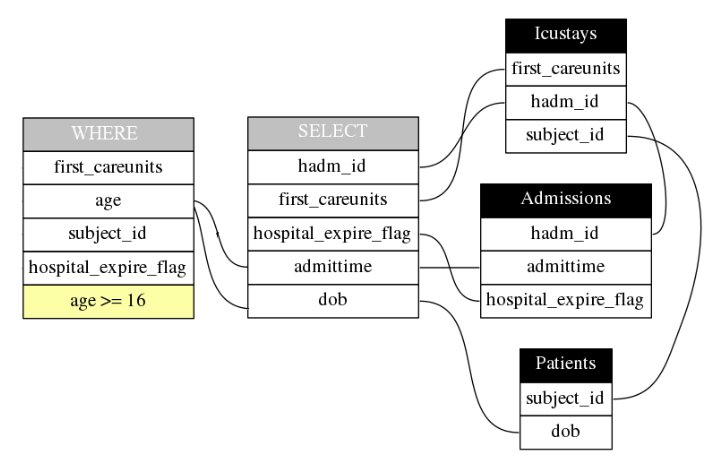

In [51]:
query = """
SELECT i.hadm_id, i.first_careunit, a.hospital_expire_flag,
round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age
FROM mimiciii.patients p
INNER JOIN mimiciii.icustays i ON p.subject_id = i.subject_id
INNER JOIN mimiciii.admissions a ON i.hadm_id = a.hadm_id
WHERE round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16;
"""

In [53]:
query_output = pd.read_sql_query(query,con)
query_output.head()

,hadm_id,first_careunit,hospital_expire_flag,age
0,110404,MICU,1,65.9770
1,106296,MICU,0,40.1007
2,188028,CCU,0,80.0778
3,173727,MICU,0,45.6869
4,164716,CCU,0,67.0976


In [54]:
print('Total hospital mortality numbers: ', query_output.drop_duplicates(['hadm_id']).groupby('hospital_expire_flag').hospital_expire_flag.count())

Total hospital mortality numbers:  hospital_expire_flag
0    44037
1     5748
Name: hospital_expire_flag, dtype: int64


In [55]:
print('Hospital mortality numbers per intensive care unit: ')
print(query_output.drop_duplicates(['hadm_id']).groupby(['first_careunit', 'hospital_expire_flag']).hospital_expire_flag.count())

Hospital mortality numbers per intensive care unit: 
first_careunit  hospital_expire_flag
CCU             0                        6441
                1                         816
CSRU            0                        8278
                1                         363
MICU            0                       16909
                1                        2860
SICU            0                        7091
                1                        1020
TSICU           0                        5318
                1                         689
Name: hospital_expire_flag, dtype: int64


In [56]:
# Or in percentages:
print('Percentages mortality (% of total admissions): ', query_output.drop_duplicates(['hadm_id'])
      .groupby('hospital_expire_flag').hospital_expire_flag.count() / query_output.drop_duplicates(['hadm_id'])
      .hospital_expire_flag.count() * 100)
print('Percentages mortality per intensive care unit: ')
print(query_output.drop_duplicates(['hadm_id']).groupby(['first_careunit', 'hospital_expire_flag'])
      .hospital_expire_flag.count() / query_output.drop_duplicates(['hadm_id']).groupby('first_careunit')
      .hospital_expire_flag.count() * 100)

Percentages mortality (% of total admissions):  hospital_expire_flag
0    88.454354
1    11.545646
Name: hospital_expire_flag, dtype: float64
Percentages mortality per intensive care unit: 
first_careunit  hospital_expire_flag
CCU             0                       88.755684
                1                       11.244316
CSRU            0                       95.799097
                1                        4.200903
MICU            0                       85.532905
                1                       14.467095
SICU            0                       87.424485
                1                       12.575515
TSICU           0                       88.530048
                1                       11.469952
Name: hospital_expire_flag, dtype: float64


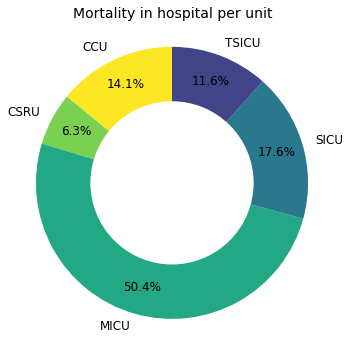

In [57]:
# Visualize with a piechart:
total = 0.0
percentages = []
for c in care_units:
    percentages.append(query_output.loc[(query_output['first_careunit'] == c) & (query_output['hospital_expire_flag'] == 1)].shape[0])
    total += percentages[-1]
total = len(care_units) * [total]
percentages = np.array(percentages) / np.array(total) * 100
colors=cm.get_cmap("viridis_r")
colors = colors(np.arange(5)/5.)
fig1, ax1 = plt.subplots(figsize=(5, 5))
patches, texts, autotexts = ax1.pie(percentages, labels = care_units, autopct = '%1.1f%%', startangle = 90,colors = colors, pctdistance = 0.8)
for i in range(len(texts)):
    texts[i].set_fontsize('large')
    texts[i].set_fontweight('roman')
    autotexts[i].set_fontsize('large')
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Mortality in hospital per unit', fontsize='14', fontweight='roman') 
ax1.axis('equal')      
fig1.tight_layout() 
fig1.savefig('figures/mortality_hospital_piechart.jpg', dpi=400) 